In [1]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import pandas as pd
import os, time, gc, datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
import lime
import lime.lime_tabular
np.random.seed(1)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [2]:
def load_data():
    
    train_transaction = pd.read_csv("train_transaction.csv")
    train_identity = pd.read_csv("train_identity.csv")
    data=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
    
    return data

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
data = load_data()
data=reduce_mem_usage(data)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


In [5]:
print(data.shape)

(590540, 434)


In [6]:
#Removing all V columns 

V_cols = [x for x in data.columns if x[0] == 'V']
data = data.drop(columns = V_cols, axis = 1)
print(data.shape)

(590540, 95)


In [7]:
data = data.sort_values('TransactionDT')
print(data.shape)

(590540, 95)


In [8]:
#Removing all ID columns 

data = data.drop(columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
                 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
                 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'], axis = 1)

print(data.shape)

(590540, 57)


In [9]:
#Removing all Categorical columns 

data= data.drop(columns= ['ProductCD','DeviceType','DeviceInfo','TransactionID', 'P_emaildomain','R_emaildomain',   
                          'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4','card5', 'card6','dist1', 'dist2', 
                    'D1', 'D2', 'D3', 'D4','D5', 'D6', 'D7', 'D8', 'D9', 'D10','D11','D12', 'D13', 'D14', 'D15', 
                        'M1','M2', 'M3','M4', 'M5',  'M6', 'M7', 'M8', 'M9'], axis = 1)

print(data.shape)

(590540, 17)


In [10]:
data.head()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,86400,68.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,86401,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,86469,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,86499,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,86506,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [11]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['Date']

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

In [12]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object'):
        data[i] = number.fit_transform(data[i].astype('str'))
        data[i] = data[i].astype('object')

In [13]:
d1 = datetime.datetime(2018, 5, 1)
train = data[data['Date']<d1]
test = data [data['Date']>= d1]

y = train['isFraud'].copy()
conta = sum(y) / len(y)

df  = train.drop(columns = ['Date'], axis = 1)
X = df.drop(columns = ['isFraud'], axis = 1)

X_test1 = test.drop('Date', axis = 1)
X_test  = test.drop(columns = ['isFraud', 'Date'], axis = 1)
y_test = X_test1['isFraud'].copy()

In [14]:
# Handling missing value

from sklearn.impute import SimpleImputer

print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df[:] = imp_mean.fit_transform(df.replace(np.inf, 99999).values)


Filling NaNs with mean


In [15]:
# Handling missing value

print('Filling NaNs with mean')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test[:] = imp_mean.fit_transform(X_test.replace(np.inf, 99999).values)

Filling NaNs with mean


In [16]:
feat = X.columns
print(feat)

Index(['TransactionDT', 'TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'],
      dtype='object')


### TreeInterpreter for interpreting decision tree with Lime

In [17]:
from treeinterpreter import treeinterpreter as ti

dt = DecisionTreeClassifier().fit(X, y) 

In [18]:
prediction, bias, contrib = ti.predict(dt, X_test)
prediction[0]

array([1., 0.])

In [19]:
#Using LIME library

explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=feat, discretize_continuous=False)

i = 0
exp = explainer.explain_instance(X.loc[i, feat].astype(int).values, dt.predict_proba, num_features=5, top_labels=2)
exp.show_in_notebook(show_table=True,  predict_proba= True , show_predicted_value = True , show_all=False)

### Check and visulaize Fraud to Non-fraud Ratio

In [20]:
All = df.shape[0]
fraud = df[df['isFraud'] == 1]
normal = df[df['isFraud'] == 0]

x = len(fraud)/All
y = len(normal)/All

print('Frauds :',x*100,'%')
print('Non-Frauds :',y*100,'%')

Frauds : 3.503221156645179 %
Non-Frauds : 96.49677884335482 %


In [21]:
df=df.sample(frac=0.7, random_state=1)

outlier_frac=len(fraud)/float(len(normal))
print(outlier_frac)

print('Fraud cases: {}'.format(len(fraud)))
print('Non-Fraud cases: {}'.format(len(normal)))

0.036304021736642926
Fraud cases: 17450
Non-Fraud cases: 480663


In [22]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# Transaction class against the Frequency
labels = ['Normal','Fraud']
classes = pd.value_counts(df['isFraud'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction distribution")
plt.xticks(range(2), labels)
plt.xlabel("isFraud")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

### Analysis the distribution of Transaction Amount

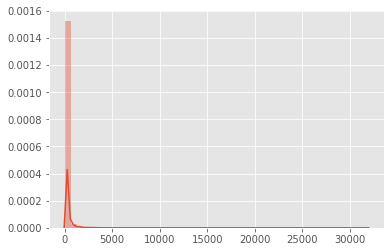

In [23]:
import seaborn as sns

# distribution of Amount
amount = [df['TransactionAmt'].values]
sns.distplot(amount)

#### Check how different are the transaction amounts in Normal and Fraud cases

In [24]:
fraud.TransactionAmt.describe() #In case of Fraud maximum trasaction is around 5200

count    17450.000000
mean       148.789539
std        227.974086
min          0.291992
25%         35.968750
50%         77.000000
75%        169.000000
max       5192.000000
Name: TransactionAmt, dtype: float64

In [25]:
normal.TransactionAmt.describe() #In case of Normal maximum trasaction is around 32000

count    480663.000000
mean        134.015081
std         237.950615
min           0.250977
25%          43.937500
50%          68.500000
75%         121.750000
max       31936.000000
Name: TransactionAmt, dtype: float64

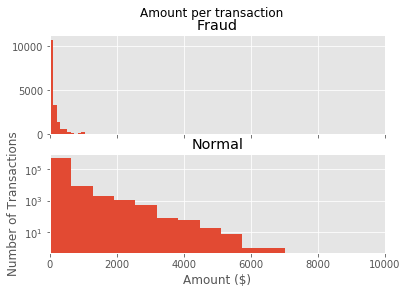

In [26]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction')
bins = 50
ax1.hist(fraud.TransactionAmt, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.TransactionAmt, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show();


### Correlation Matrix Heatmap

In [27]:
df.corr()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
isFraud,1.000000,0.019380,0.011363,0.031248,0.038049,-0.006635,0.030596,-0.031345,0.021089,0.030395,0.033249,-0.032823,0.030045,0.027953,0.033921,-0.008851,0.008281
TransactionDT,0.019380,1.000000,0.012375,-0.053127,-0.055116,-0.016333,-0.060217,0.028990,-0.052067,-0.057703,-0.060279,0.036698,-0.061600,-0.054814,-0.056910,-0.019149,-0.044663
TransactionAmt,0.011363,0.012375,1.000000,-0.019115,-0.019837,-0.005829,-0.012346,-0.029878,-0.018670,-0.018032,-0.016188,-0.029044,-0.017285,-0.018854,-0.018122,-0.039605,-0.023806
C1,0.031248,-0.053127,-0.019115,1.000000,0.995170,-0.003321,0.971091,0.156634,0.984077,0.938728,0.971846,0.166651,0.962769,0.996632,0.940439,0.791554,0.955596
C2,0.038049,-0.055116,-0.019837,0.995170,1.000000,-0.003171,0.975492,0.118295,0.977457,0.949982,0.979117,0.125056,0.974388,0.994359,0.951400,0.769783,0.941301
C3,-0.006635,-0.016333,-0.005829,-0.003321,-0.003171,1.000000,-0.001670,-0.007660,-0.004473,-0.001747,-0.001233,-0.009448,-0.001542,-0.003399,-0.001774,-0.007128,-0.004814
C4,0.030596,-0.060217,-0.012346,0.971091,0.975492,-0.001670,1.000000,-0.013337,0.964925,0.916470,0.968391,-0.016451,0.961726,0.977115,0.916023,0.673490,0.914224
C5,-0.031345,0.028990,-0.029878,0.156634,0.118295,-0.007660,-0.013337,1.000000,0.222153,-0.010665,-0.012184,0.922632,-0.012401,0.159845,-0.010638,0.693576,0.364687
C6,0.021089,-0.052067,-0.018670,0.984077,0.977457,-0.004473,0.964925,0.222153,1.000000,0.882606,0.933286,0.240970,0.926601,0.992132,0.882207,0.825411,0.985157
C7,0.030395,-0.057703,-0.018032,0.938728,0.949982,-0.001747,0.916470,-0.010665,0.882606,1.000000,0.986247,-0.013155,0.988072,0.930883,0.999526,0.664250,0.823302


In [28]:
df_scaled = df.drop(['isFraud','TransactionDT'],axis = 1,inplace=False)
df_scaled.head()

,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
430095,57.937500,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0
312504,107.937500,3.0,3.0,0.0,0.0,8.0,3.0,0.0,0.0,4.0,0.0,4.0,0.0,20.0,3.0
177165,24.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0
406944,171.000000,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,8.0,2.0
210081,14.109375,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


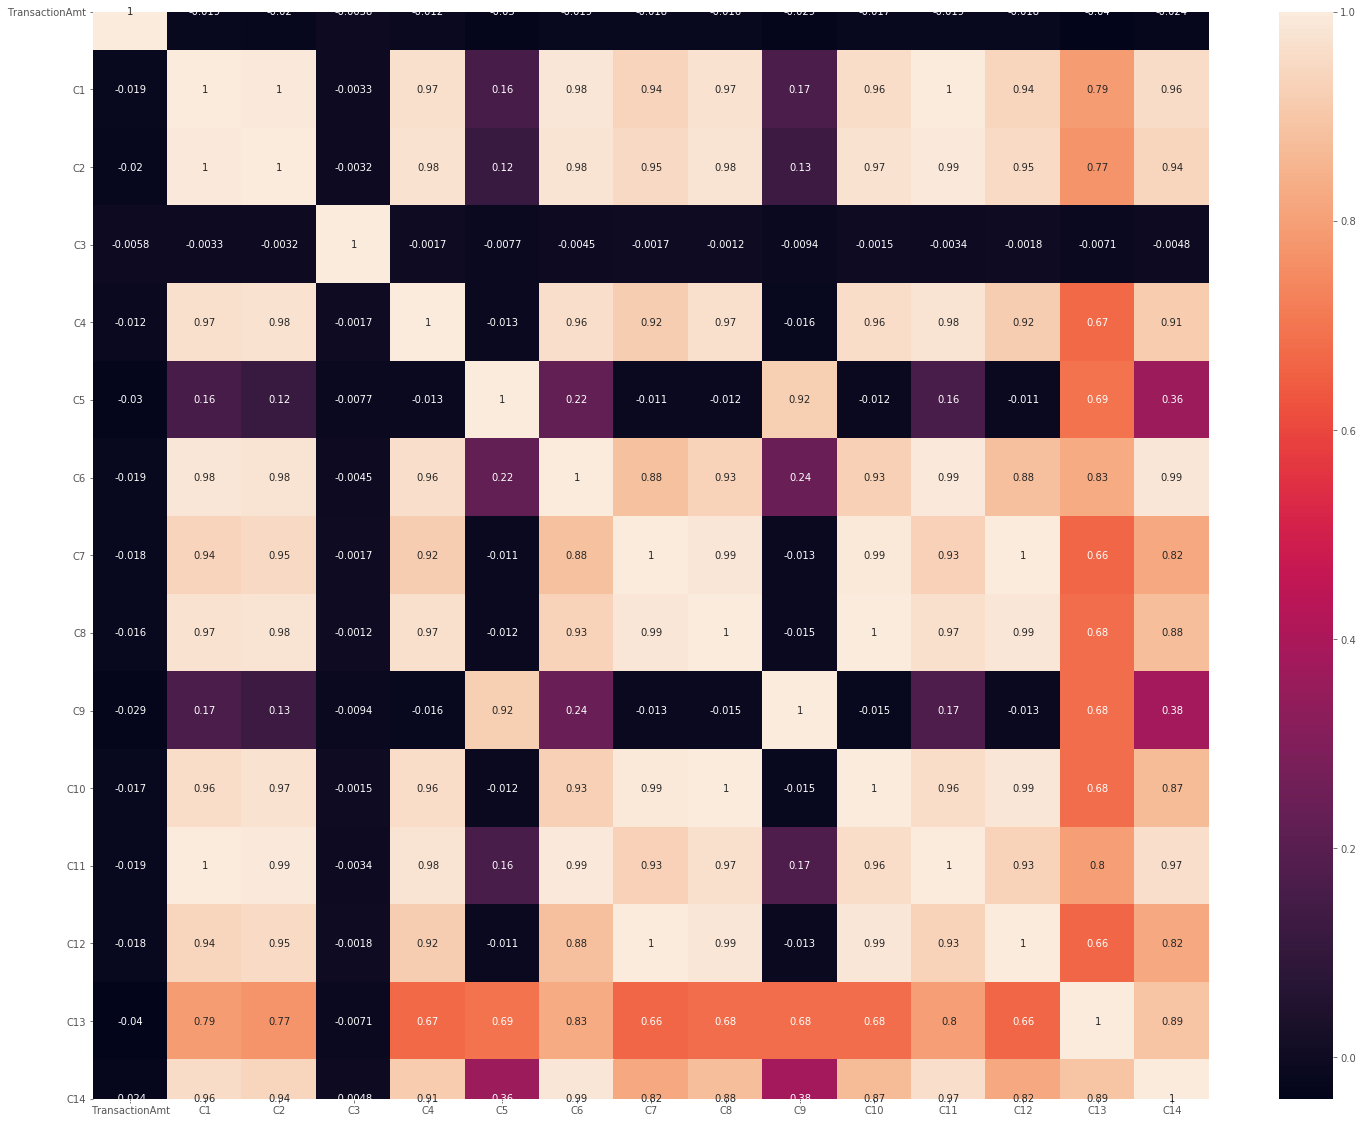

In [29]:
plt.figure(figsize=(25,20))
sns.heatmap(df_scaled.corr(),annot=True)
plt.show()

In [30]:
#We select features that show correlation

cordata=df_scaled[['C1','C2','C4','C6','C7', 'C8','C10','C11','C12','C14']]
cordata.head()

,C1,C2,C4,C6,C7,C8,C10,C11,C12,C14
430095,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
312504,3.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,3.0
177165,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
406944,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0
210081,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


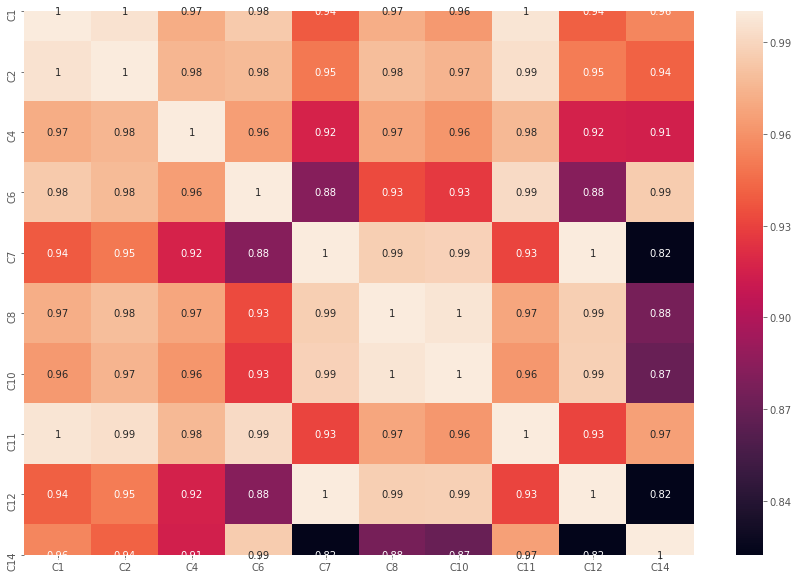

In [31]:
plt.figure(figsize=(15,10))
sns.heatmap(cordata.corr(),annot=True)
plt.show()

### Transaction Amount Visualization

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


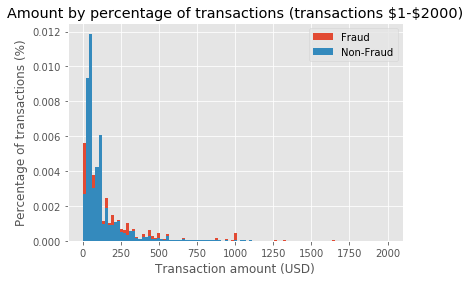

In [32]:
# Plot of high value transactions($1-$2000)
bins = np.linspace(1, 2000, 100)
plt.hist(fraud.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(normal.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$1-$2000)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


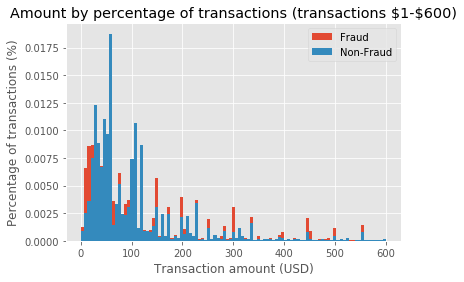

In [33]:
# Plot of high value transactions($1-$600)
bins = np.linspace(1, 600, 100)
plt.hist(fraud.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(normal.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$1-$600)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hs/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


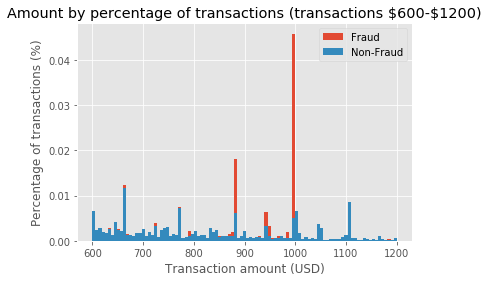

In [34]:
# Plot of high value transactions($600-$1200)
bins = np.linspace(600, 1200, 100)
plt.hist(fraud.TransactionAmt, bins, alpha=1, normed=True, label='Fraud')
plt.hist(normal.TransactionAmt, bins, alpha=1, normed=True, label='Non-Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$600-$1200)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

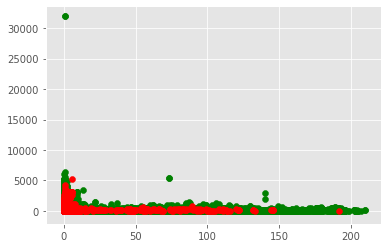

In [35]:
#y axis is Transaction Amount, x axis is C9
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(normal['C9'],normal['TransactionAmt'],c='g') #Green is normal
ax.scatter(fraud['C9'],fraud['TransactionAmt'],c='r')  #Red is Fraud
plt.show()

### Destributions of features in Fraud cases 

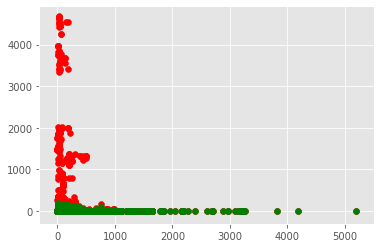

In [36]:
#we have seen almost the same graph for C1, C2, C4, C6, C7, C8, C9, C10, C11, C12, C13, C14

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(fraud['TransactionAmt'],fraud['C1'], c='r') #C1 is red
ax.scatter(fraud['TransactionAmt'],fraud['C9'], c='g') #C9 is green
plt.show() 

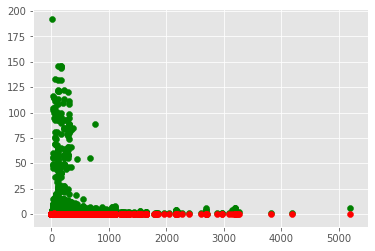

In [37]:
#This graph looks intersting, because C9 shows hight destribution compared to C3

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(fraud['TransactionAmt'],fraud['C9'], c='g') #C9 is green
ax.scatter(fraud['TransactionAmt'],fraud['C3'], c='r') #C3 is red

plt.show() 

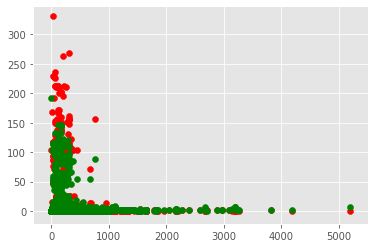

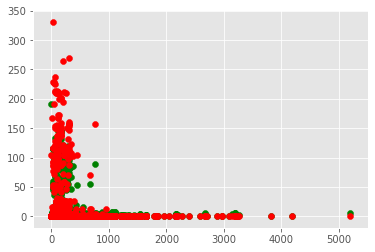

In [38]:
#This graph looks intersting because both C9 and C5 shows almost the same destribution

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(fraud['TransactionAmt'],fraud['C5'], c='r') #C5 is red
ax1.scatter(fraud['TransactionAmt'],fraud['C9'], c='g') #C9 is green

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.scatter(fraud['TransactionAmt'],fraud['C9'], c='g') #C9 is green
ax2.scatter(fraud['TransactionAmt'],fraud['C5'], c='r') #C5 is red

plt.show()

plt.show()

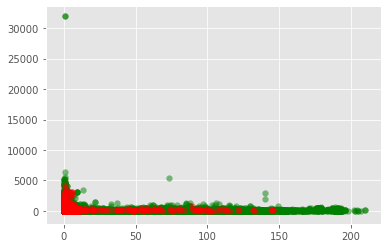

In [39]:
# Plot how fraud and non-fraud cases are scattered (x is C9, y is TransactionAmt)

plt.scatter(df.loc[df['isFraud'] == 0]['C9'], df.loc[df['isFraud'] == 0]['TransactionAmt'],  label="isFraud #0", alpha=0.5, linewidth=0.15, c='g')
plt.scatter(df.loc[df['isFraud'] == 1]['C9'], df.loc[df['isFraud'] == 1]['TransactionAmt'], label="isFraud #1", alpha=0.5, linewidth=0.15,c='r')
plt.show()